In [1]:

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm

import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA

# The SVD calc takes a long time to run (about 2 minutes on a macbook M2)
# Set this flag to False if you want to load the pre-computed SVD vals.
RunSVD=False

# Save figures?
SaveFigs=True

# Choose a device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device='cpu'
print('Device =',device)

torch.manual_seed(1)

# Number of neurons in recurrent net
N = 200

# Duration of simulation in ms
T = 100
dt = 0.01
time = np.arange(0,T,dt)
Nt = len(time)



# Parameters for connectivity matrix
c=-.5
rho=0.1

cx=1

sigmaw=0.05
sigmax=0.1


# Time step size, timescale of dynamics
dt = 0.01
tau=1



# Connectivity

# Compute pairwise differences between all pairs of
# values in the vectors x and y
def PairwiseDifferences(x,y):
    return x.unsqueeze(1) - y

# Univariate Gaussian pdf
def Gaussian(x,mu,sigma):
    sqrt2pi = 2.5066282746310002
    return torch.exp(-(x-mu)**2/(2*sigma**2))/(sigma*sqrt2pi)

# Univariate wrapped Gaussian on [0,1)
def WrappedGaussian(x,mu,sigma,num_wraps):
    g=0
    for w in range(-num_wraps,num_wraps+1):
        g += Gaussian(x+w,mu,sigma)
    return g

theta=(torch.tensor(range(N))/N).to(device)

W0 = c*WrappedGaussian(PairwiseDifferences(theta,theta),0,sigmaw,2)/np.sqrt(N)


W1 = rho*torch.randn(N,N).to(device)/np.sqrt(N)
W = W0 + W1


# Coefficient for RNN Euler integrator
eta = dt/tau

# Model and random model
model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)

# singular values and eigenvalues of connectivity
with torch.no_grad():
    UW0,sigmaW0,VW0T = torch.linalg.svd(W0.cpu())
    VW0=VW0T.T
    #lamW = torch.linalg.eigvals(W.cpu())
    #print('max real e-val of W:',torch.real(lamW).max().item())



u = UW0[:,0]
v = VW0[:,0]
urand = torch.randn(N)
urand = urand/urand.norm()

####### Second simulation for PCA plot

# Duration of sim
T2=5000

# Timescale and strength of Guassian random stimulus
taux=10
sigmax=.5

# Discretized time for second sim
time2=np.arange(0,T2,dt)
Nt2=len(time2)


# Generate input and run sim
with torch.no_grad():
    t0=tm()
    x2 = sigmax*MakeSmoothGaussianProcess(taux,Nt2,dt,N,device=device).T
    x2 = x2[None,:,:].float().to(device)
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')
    t0=tm()
    r2 = model(x2, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z2 = model.hidden_state_history
    
    tsim2 = tm()-t0
    print('Time for second sim:',tsim2,'s')

    # Perform PCA on x and z
    t0=tm()
    Nburn=int(100/dt)
    Ux,Sx=TorchPCA(x2[0,Nburn:,:], scaled=False)
    Uz,Sz=TorchPCA(z2[0,Nburn:,:], scaled=False)
    print('Time for PCA calc:',tm()-t0)


    # Get input variable
    y2=model.recurrent_layer(r2)



    # Define projected variables
    xu = x2[0,:,:]@u
    xurand = x2[0,:,:]@urand
    zu = z2[0,:,:]@u
    zurand = z2[0,:,:]@urand
    yu = y2[0,:,:]@u
    ru = r2[0,:,:]@u

    # Define projected variables
    xv = x2[0,:,:]@v
    zv = z2[0,:,:]@v
    yv = y2[0,:,:]@v
    rv = r2[0,:,:]@v

    xycorr = torch.corrcoef(torch.stack((xu,yu)))[0,1].item()
    print('corr coef between xu and yu=Wru:',xycorr)


    uuangle=(180/np.pi)*torch.arccos(torch.nn.functional.cosine_similarity(Uz[:,-1],u.cpu(),dim=0)).item()
    print('Angle btwn smallest sing vec and u:',uuangle,'degrees')




Device = cpu
Time to generate x(t): 1.4683501720428467 s
Time for second sim: 12.903838872909546 s
Time for PCA calc: 2.878969192504883
corr coef between xu and yu=Wru: -0.9920482635498047
Angle btwn smallest sing vec and u: 43.69427398860775 degrees


done


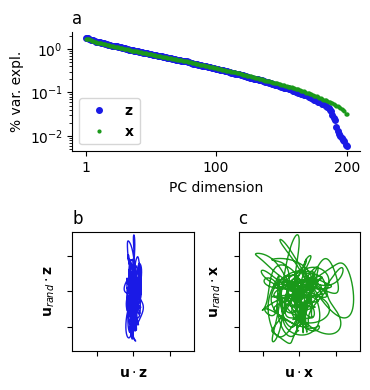

In [2]:


### Make Figure
xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N

fig, axes = plt.subplot_mosaic("aa;bc",figsize=(3.8,4))

c0='a'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,100*Sz/Sz.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
#ax0.plot(np.arange(N)+1,100*SCzlin/SCzlin.sum(),'.',label=r'$\mathbf{z}\;(W=W_1)$',markersize=2,color='r')
ax0.set_xscale('linear')
ax0.set_yscale('log')
ax0.set_xlabel('PC dimension')
ax0.set_xticks([1,int(N/2),N])
#ax0.set_yticks([10, 100])
ax0.set_ylabel('% var. expl.')
ax0.legend(loc='lower left')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)



c0='b'
ax0 = axes[c0]
xumax=torch.max(torch.cat((torch.abs(xu),torch.abs(xurand)))).item()
zumax=torch.max(torch.cat((torch.abs(zu),torch.abs(zurand)))).item()
xzumax=max(xumax,zumax)

I2plot=int(2000/dt)
numplot=N
ax0.plot(ToNP(zu[:I2plot]),ToNP(zurand[:I2plot]),color=zclr,lw=1)
ax0.axis([-xzumax,xzumax,-xzumax,xzumax])
ax0.set_xticks([-1,0,1])
ax0.set_yticks([-1,0,1])
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xlabel(r'$\mathbf{u}\cdot\mathbf{z}$')
ax0.set_ylabel(r'$\mathbf{u}_{rand}\cdot\mathbf{z}$')
ax0.set_title(c0,loc='left')

c0='c'
ax0 = axes[c0]
ax0.plot(ToNP(xu[:I2plot]),ToNP(xurand[:I2plot]),color=xclr,lw=1)
ax0.axis([-xzumax,xzumax,-xzumax,xzumax])
ax0.set_xticks([-1,0,1])
ax0.set_yticks([-1,0,1])
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xlabel(r'$\mathbf{u}\cdot\mathbf{x}$')
ax0.set_ylabel(r'$\mathbf{u}_{rand}\cdot\mathbf{x}$')
ax0.set_title(c0,loc='left')


fig.tight_layout()


if SaveFigs:
    fig.savefig('./Figures/SuppFigSpace.pdf')
    fig.savefig('./Figures/SuppFigSpaceunpolished.svg')
print('done')

